In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd

def bootstrap(invec):
    idx = npr.randint(0, len(invec), len(invec))
    return [invec[i] for i in idx]

def estimatePi0(p, numBoot=100, numLambda=100, maxLambda=0.95):
    p.sort()
    n=len(p)
    lambdas=np.linspace(maxLambda/numLambda,maxLambda,numLambda)
    Wls=np.array([n-np.argmax(p>=l) for l in lambdas])
    pi0s=np.array([Wls[i] / (n * (1 - lambdas[i])) for i in range(numLambda)])
    minPi0=np.min(pi0s)
    mse = np.zeros(numLambda)
    for boot in range(numBoot):
        pBoot = bootstrap(p)
        pBoot.sort()
        WlsBoot =np.array([n-np.argmax(pBoot>=l) for l in lambdas])
        pi0sBoot =np.array([WlsBoot[i] / (n *(1 - lambdas[i])) for i in range(numLambda)])
        mse = mse + np.square(pi0sBoot-minPi0)
    minIx = np.argmin(mse)
    return pi0s[minIx]

# The input to this function is tupples of p-values and analyte names, e.g. (p,coord)
def qvalues(pvalues):
    m=len(pvalues)
    pvalues.sort()
    pi0 = estimatePi0([p for p,coord in pvalues])
    num_p, qs = 0.0, []
    for p,coord in pvalues:
        num_p += 1.0
        q = pi0*p*m/num_p
        qs.append((q,p,coord))
    qs.reverse()
    old_q=1.0
    for ix in range(len(qs)):
        q = min(old_q,qs[ix][0])
        old_q = q
        qs[ix] = (q,qs[ix][1],qs[ix][2])
    qs.reverse()
    return qs

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
expression = pd.read_excel("MSB-12-901-s009.xlsx",skiprows=range(6)+range(7,18),parse_cols=[0]+range(3,318),header=0,index_col=0)
weights = pd.read_excel("MSB-12-901-s009.xlsx",skiprows=range(6)+range(8,755),parse_cols=[0]+range(3,318),header=0,index_col=0)
print expression.shape
print weights.shape

(737, 315)
(1, 315)


In [3]:
weights.loc["Subject_id",:] = [int(coln.split('_')[1]) for coln in weights.columns.values]
weights.loc["Time",:] = [int(coln.split('_')[2]) for coln in weights.columns.values]
from_w = ['_{0:02d}_{1:d}'.format(int(i),1) for i in weights.loc["Subject_id"]]
to_w = ['_{0:02d}_{1:d}'.format(int(i),int(j)) for i,j in zip(weights.loc["Subject_id"],weights.loc["Time"])]
from_w = [s.replace('_01', '_1') for s in from_w]
from_w = [s.replace('_44_1', '_44_2') for s in from_w]
to_w = [s.replace('_01', '_1') for s in to_w]

delta_w = [weights.loc["Weight",to] - weights.loc["Weight",fr] for to,fr in zip(to_w,from_w)]
weights.loc["dW",:]=delta_w
df = pd.concat([weights,expression])
df = df.loc[:,df.loc["Weight"].notnull()]
df.dropna(inplace=True,axis=0)
df.shape

(205, 313)

In [4]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
header_rows = ["Subject_id", "Time", "Weight"]
pv,sub_var = [],{}
for name,values in df.iterrows():
    if name in header_rows:
        continue
    subframe = df.loc[header_rows+[name],:].T.copy()
    renam = {name:'Expression'}
    subframe.rename(columns=renam,inplace=True)
    formula = 'Expression ~ C(Subject_id) + C(Time)'
    model = ols(formula,subframe).fit()
    sub_var[name] = model.params.filter(regex=("C.*Subject_id.*")).var()
    table = sm.stats.anova_lm(model, typ=2)
    pvalue = table.loc['C(Time)'][-1]
    pv.append((pvalue,name))
qv = qvalues(pv)

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


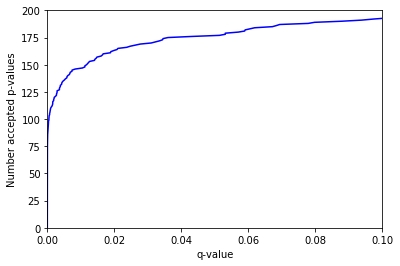

In [5]:
import matplotlib.pyplot as plt
plt.plot([q[0] for q in qv],range(len(qv)),'b-')
plt.ylabel("Number accepted p-values")
plt.xlabel("q-value")
plt.xlim(0,0.1)
plt.ylim(0,200)
plt.show()

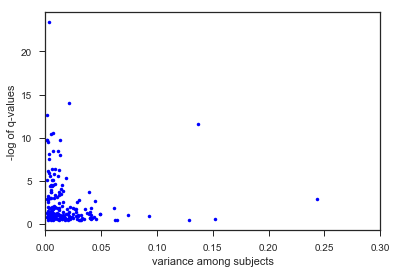

In [15]:
plt.plot([sub_var[q[2]] for q in qv],[-np.log10(q[0]) for q in qv],'b.')
plt.ylabel("-log of q-values")
plt.xlabel("variance among subjects")
plt.xlim(.0,0.3)
plt.show()

Lets do the same thing but for a different model

In [7]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
header_rows = ["Subject_id", "Time", "Weight","dW"]
pv,sub_var = [],{}
for name,values in df.iterrows():
    if name in header_rows:
        continue
    subframe = df.loc[header_rows+[name],:].T.copy()
    renam = {name:'Expression'}
    subframe.rename(columns=renam,inplace=True)
    formula = 'Expression ~ C(Subject_id) + dW'
    model = ols(formula,subframe).fit()
    sub_var[name] = model.params.filter(regex=("C.*Subject_id.*")).var()
    table = sm.stats.anova_lm(model, typ=2)
    pvalue = table.loc['dW'][-1]
    pv.append((pvalue,name))
qv = qvalues(pv)

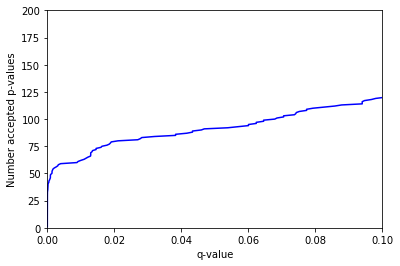

In [8]:
plt.plot([q[0] for q in qv],range(1,len(qv)+1),'b-')
plt.ylabel("Number accepted p-values")
plt.xlabel("q-value")
plt.xlim(0,0.1)
plt.ylim(0,200)
plt.show()

P36955


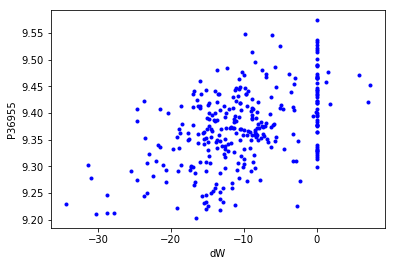

In [9]:
best_analyte = qv[0][2]
print best_analyte
plt.plot([df.loc["dW",:]],[df.loc[best_analyte,:]],'b.')
plt.ylabel(best_analyte)
plt.xlabel("dW")
plt.show()

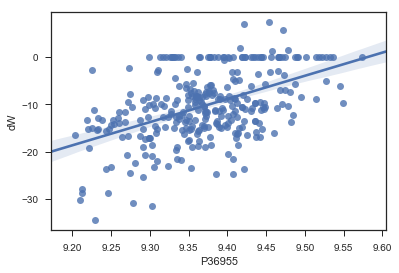

In [10]:
subframe = df.loc[header_rows+[best_analyte],:].T.copy()
import seaborn as sns
sns.set(style="ticks")
g = sns.regplot(y="dW", x=best_analyte, data=subframe)

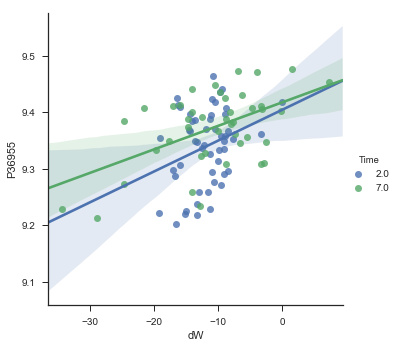

In [16]:
subframe = df.loc[header_rows+[best_analyte],df.loc["Time",:].isin([2,7])].T.copy()
import seaborn as sns
sns.set(style="ticks")
g = sns.lmplot(x="dW", y=best_analyte, hue="Time",data=subframe)

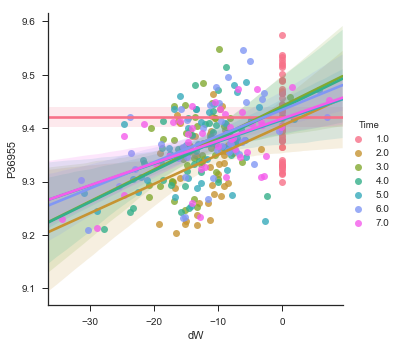

In [17]:
subframe = df.loc[header_rows+[best_analyte],:].T.copy()
import seaborn as sns
sns.set(style="ticks")
g = sns.lmplot(x="dW", y=best_analyte, hue="Time",data=subframe)